In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import time
from torch.utils.data import Dataset
import pandas as pd
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR

In [2]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# # Specify the folder where the CIFAR-10 batch files are
# cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'

# # Load the label names
# meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
# label_names = meta_data_dict[b'label_names']

# # Load one batch for demonstration (e.g., data_batch_1)
# batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
# train_images = batch_1_dict[b'data']
# train_labels = batch_1_dict[b'labels']

# # Reshape the images
# train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# # Display the first 10 images and labels
# plt.figure(figsize=(20, 4))
# for i in range(10):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(train_images[i])
#     plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
#     plt.axis('off')
# plt.show()

# Preparing Training & Validation Dataset

In [3]:
def load_training_data(cifar10_dir):
    # Placeholder for combined data and labels
    combined_images = []
    combined_labels = []
    
    # Iterate over the training batch files and load them
    for i in range(1, 6): # There are 5 training batches
        batch_name = f'data_batch_{i}'
        batch_path = os.path.join(cifar10_dir, batch_name)
        batch_data = load_cifar_batch(batch_path)
        
        # Append data and labels to the combined lists
        combined_images.append(batch_data[b'data'])
        combined_labels.append(batch_data[b'labels'])
    
    # Convert lists to numpy arrays and reshape images
    combined_images = np.vstack(combined_images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    combined_labels = np.hstack(combined_labels)
    
    return combined_images, combined_labels

In [4]:
def load_validation_data(cifar10_dir):
    batch_name = 'test_batch'
    batch_path = os.path.join(cifar10_dir, batch_name)
    batch_data = load_cifar_batch(batch_path)
    
    images = batch_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(batch_data[b'labels'])
    
    return images, labels

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, H, W, C)
        labels: NumPy array of labels
        transform: torchvision transforms to apply to each image
        """
        # Convert images from NHWC to NCHW format expected by PyTorch
        self.images = images.transpose((0, 3, 1, 2))
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert the NumPy array to a PIL Image and apply transformation
        if self.transform:
            # Ensure image is a float type before applying transform
            image = torch.tensor(image, dtype=torch.float).div(255)
            image = transforms.functional.to_pil_image(image)
            image = self.transform(image)

        return image, label

In [6]:
def prepareDataset(load_data_func, cifar10_dir, transform, batch_size=16, shuffle=True):
    images, labels = load_data_func(cifar10_dir)
    dataset = CustomDataset(images, labels, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [7]:
batch_size = 64
shuffle = True
num_classes = 10
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Create DataLoaders
train_loader = prepareDataset(load_training_data, cifar10_dir, transform_train, batch_size, shuffle)
val_loader = prepareDataset(load_validation_data, cifar10_dir, transform_test, batch_size, False)

# Model 1

In [8]:
num_classes = 10

class BasicBlock(nn.Module):
    expansion = 1  # Ensures the output channel size is calculated correctly

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 248, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 248, num_blocks[3], stride=2)
        final_dim = 248 * block.expansion  # This should be the number of output channels from the last layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (1, 1) size
        self.linear = nn.Linear(final_dim, num_classes)  # Adjust the linear layer to match the final_dim

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Using the existing BasicBlock class and more conservative layer configuration
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10) # Slightly reduced blocks in layers

# Calculate the number of parameters for the new configuration
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
params_count

4936538

## Training Model 1

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
#scheduler = CosineAnnealingLR(optimizer, T_max=200)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=None, 
#                        epochs=100, steps_per_epoch=len(train_loader), pct_start=0.3)

In [12]:
def train_model(model):
    best_val_acc = 0.0

    def best_model_path(epoch):
        return f'best_model_{epoch}.pth'

    patience = 10
    patience_counter = 0
    num_epochs = 200  # Adjust as per requirement
    train_acc_list = []
    train_loss_list = []
    valid_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        correct = 0
        total = 0

        # Initialize tqdm progress bar
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update progress bar
            train_bar.set_postfix(train_acc=f"{100 * correct / total:.2f}%", loss=f"{running_loss/(train_bar.n + 1):.4f}")

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        # Initialize tqdm progress bar for validation
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validate]')

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update validation progress bar
                val_bar.set_postfix(val_acc=f"{100 * correct / total:.2f}%")

        val_accuracy = 100 * correct / total
        valid_acc_list.append(val_accuracy)

        # Save model if validation accuracy has improved
        if val_accuracy > best_val_acc:
            print(f"New best model found at epoch {epoch+1} with accuracy {val_accuracy:.2f}%.")
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path(epoch+1))
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy. Patience: {patience_counter}/{patience}")

        scheduler.step(val_accuracy)

        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation accuracy.")
            break
    
    print('Best Validation Accuracy is: ', best_val_acc)
    return train_acc_list, train_loss_list, valid_acc_list
    

In [25]:
train_acc_list, train_loss_list, valid_acc_list = train_model(model)

Epoch 1/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.48it/s, val_acc=61.66%]


New best model found at epoch 1 with accuracy 61.66%.


Epoch 2/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.47it/s, val_acc=66.41%]


New best model found at epoch 2 with accuracy 66.41%.


Epoch 3/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.67it/s, val_acc=74.42%]


New best model found at epoch 3 with accuracy 74.42%.


Epoch 4/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.33it/s, val_acc=79.23%]


New best model found at epoch 4 with accuracy 79.23%.


Epoch 5/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.02it/s, val_acc=81.38%]


New best model found at epoch 5 with accuracy 81.38%.


Epoch 6/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.50it/s, val_acc=82.29%]


New best model found at epoch 6 with accuracy 82.29%.


Epoch 7/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.70it/s, val_acc=80.37%]


No improvement in validation accuracy. Patience: 1/10


Epoch 8/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.90it/s, val_acc=82.70%]


New best model found at epoch 8 with accuracy 82.70%.


Epoch 9/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.96it/s, val_acc=84.97%]


New best model found at epoch 9 with accuracy 84.97%.


Epoch 10/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.21it/s, val_acc=86.82%]


New best model found at epoch 10 with accuracy 86.82%.


Epoch 11/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.20it/s, val_acc=86.61%]


No improvement in validation accuracy. Patience: 1/10


Epoch 12/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.33it/s, val_acc=87.56%]


New best model found at epoch 12 with accuracy 87.56%.


Epoch 13/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.84it/s, val_acc=87.74%]


New best model found at epoch 13 with accuracy 87.74%.


Epoch 14/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.79it/s, val_acc=85.80%]


No improvement in validation accuracy. Patience: 1/10


Epoch 15/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.07it/s, val_acc=88.19%]


New best model found at epoch 15 with accuracy 88.19%.


Epoch 16/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s, val_acc=87.83%]


No improvement in validation accuracy. Patience: 1/10


Epoch 17/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.82it/s, val_acc=89.38%]


New best model found at epoch 17 with accuracy 89.38%.


Epoch 18/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.10it/s, val_acc=88.97%]


No improvement in validation accuracy. Patience: 1/10


Epoch 19/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.38it/s, val_acc=89.81%]


New best model found at epoch 19 with accuracy 89.81%.


Epoch 20/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.26it/s, val_acc=89.44%]


No improvement in validation accuracy. Patience: 1/10


Epoch 21/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s, val_acc=89.62%]


No improvement in validation accuracy. Patience: 2/10


Epoch 22/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.02it/s, val_acc=89.14%]


No improvement in validation accuracy. Patience: 3/10
Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


Epoch 23/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.96it/s, val_acc=91.99%]


New best model found at epoch 23 with accuracy 91.99%.


Epoch 24/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.99it/s, val_acc=92.23%]


New best model found at epoch 24 with accuracy 92.23%.


Epoch 25/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.85it/s, val_acc=92.39%]


New best model found at epoch 25 with accuracy 92.39%.


Epoch 26/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 28.52it/s, val_acc=92.52%]


New best model found at epoch 26 with accuracy 92.52%.


Epoch 27/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.28it/s, val_acc=92.44%]


No improvement in validation accuracy. Patience: 1/10


Epoch 28/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.47it/s, val_acc=92.27%]


No improvement in validation accuracy. Patience: 2/10


Epoch 29/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.23it/s, val_acc=92.05%]


No improvement in validation accuracy. Patience: 3/10
Epoch 00029: reducing learning rate of group 0 to 1.0000e-05.


Epoch 30/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.31it/s, val_acc=92.42%]


No improvement in validation accuracy. Patience: 4/10


Epoch 31/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.52it/s, val_acc=92.44%]


No improvement in validation accuracy. Patience: 5/10


Epoch 32/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.12it/s, val_acc=92.48%]


No improvement in validation accuracy. Patience: 6/10
Epoch 00032: reducing learning rate of group 0 to 1.0000e-06.


Epoch 33/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.69it/s, val_acc=92.44%]


No improvement in validation accuracy. Patience: 7/10


Epoch 34/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.42it/s, val_acc=92.58%]


New best model found at epoch 34 with accuracy 92.58%.


Epoch 35/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.06it/s, val_acc=92.45%]


No improvement in validation accuracy. Patience: 1/10


Epoch 36/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.20it/s, val_acc=92.43%]


No improvement in validation accuracy. Patience: 2/10


Epoch 37/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.31it/s, val_acc=92.62%]


New best model found at epoch 37 with accuracy 92.62%.


Epoch 38/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.42it/s, val_acc=92.55%]


No improvement in validation accuracy. Patience: 1/10


Epoch 39/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s, val_acc=92.62%]


No improvement in validation accuracy. Patience: 2/10


Epoch 40/40 [Validate]: 100%|██████████| 157/157 [00:05<00:00, 29.49it/s, val_acc=92.56%]

No improvement in validation accuracy. Patience: 3/10
Epoch 00040: reducing learning rate of group 0 to 1.0000e-07.
Best Validation Accuracy is:  92.62


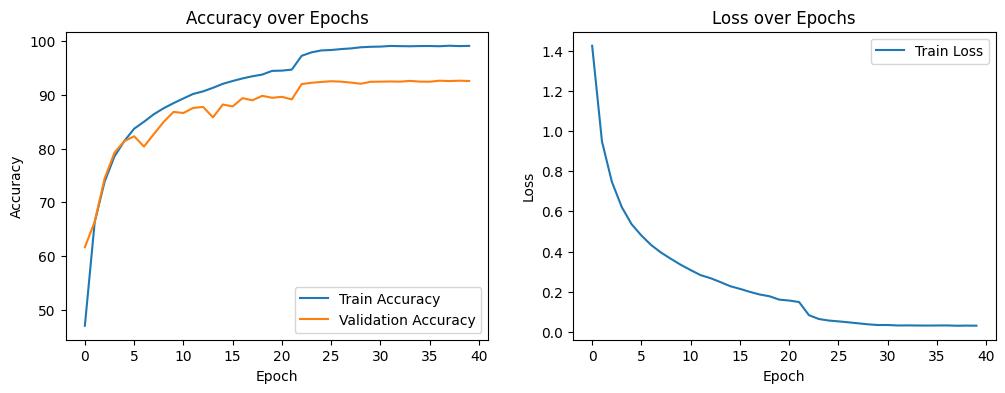

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(valid_acc_list, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model 2

In [13]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin, stride=stride)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)
        self.bn = nn.BatchNorm2d(nout)  # Batch normalization after pointwise convolution

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.bn(out)  # Applying batch normalization
        return out

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        mid_channels = out_channels // 3
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = DepthwiseSeparableConv(mid_channels, mid_channels, stride=stride)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        ) if stride != 1 or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = self.relu(out)
        return out

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(ModifiedResNet, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 128, blocks=3, stride=1)
        self.layer2 = self._make_layer(128, 256, blocks=4, stride=2)
        self.layer3 = self._make_layer(256, 512, blocks=6, stride=2)
        self.layer4 = self._make_layer(512, 1024, blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc_extra = nn.Linear(1024, 512) 
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BottleneckBlock(in_channels, out_channels, stride))
        layers.append(nn.Dropout(self.dropout_rate))
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc_extra(x) 
        x = self.relu(x)      
        x = self.dropout(x)   
        x = self.fc(x)
        return x

# Create the model instance
model2 = ModifiedResNet()
print(f"Model2 has {sum(p.numel() for p in model2.parameters() if p.requires_grad):,} parameters")

Model2 has 4,960,378 parameters


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model2.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
#scheduler = CosineAnnealingLR(optimizer, T_max=200)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=None, 
#                        epochs=100, steps_per_epoch=len(train_loader), pct_start=0.3)

# Training Model 2

In [15]:
train_acc_list, train_loss_list, valid_acc_list = train_model(model)

Epoch 1/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.50it/s, val_acc=46.19%]


New best model found at epoch 1 with accuracy 46.19%.


Epoch 2/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.79it/s, val_acc=59.66%]


New best model found at epoch 2 with accuracy 59.66%.


Epoch 3/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.75it/s, val_acc=62.13%]


New best model found at epoch 3 with accuracy 62.13%.


Epoch 4/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.72it/s, val_acc=64.98%]


New best model found at epoch 4 with accuracy 64.98%.


Epoch 5/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s, val_acc=75.44%]


New best model found at epoch 5 with accuracy 75.44%.


Epoch 6/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.91it/s, val_acc=77.75%]


New best model found at epoch 6 with accuracy 77.75%.


Epoch 7/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.83it/s, val_acc=77.60%]


No improvement in validation accuracy. Patience: 1/10


Epoch 8/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.68it/s, val_acc=81.42%]


New best model found at epoch 8 with accuracy 81.42%.


Epoch 9/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.81it/s, val_acc=81.46%]


New best model found at epoch 9 with accuracy 81.46%.


Epoch 10/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.91it/s, val_acc=81.46%]


No improvement in validation accuracy. Patience: 1/10


Epoch 11/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.98it/s, val_acc=83.95%]


New best model found at epoch 11 with accuracy 83.95%.


Epoch 12/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.90it/s, val_acc=83.71%]


No improvement in validation accuracy. Patience: 1/10


Epoch 13/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.86it/s, val_acc=84.64%]


New best model found at epoch 13 with accuracy 84.64%.


Epoch 14/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.71it/s, val_acc=81.85%]


No improvement in validation accuracy. Patience: 1/10


Epoch 15/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.62it/s, val_acc=86.60%]


New best model found at epoch 15 with accuracy 86.60%.


Epoch 16/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.99it/s, val_acc=86.25%]


No improvement in validation accuracy. Patience: 1/10


Epoch 17/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.65it/s, val_acc=86.06%]


No improvement in validation accuracy. Patience: 2/10


Epoch 18/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.61it/s, val_acc=87.03%]


New best model found at epoch 18 with accuracy 87.03%.


Epoch 19/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.74it/s, val_acc=88.06%]


New best model found at epoch 19 with accuracy 88.06%.


Epoch 20/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.87it/s, val_acc=87.12%]


No improvement in validation accuracy. Patience: 1/10


Epoch 21/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.71it/s, val_acc=87.28%]


No improvement in validation accuracy. Patience: 2/10


Epoch 22/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.89it/s, val_acc=88.22%]


New best model found at epoch 22 with accuracy 88.22%.


Epoch 23/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, val_acc=88.16%]


No improvement in validation accuracy. Patience: 1/10


Epoch 24/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.63it/s, val_acc=88.84%]


New best model found at epoch 24 with accuracy 88.84%.


Epoch 25/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.90it/s, val_acc=88.80%]


No improvement in validation accuracy. Patience: 1/10


Epoch 26/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.69it/s, val_acc=89.58%]


New best model found at epoch 26 with accuracy 89.58%.


Epoch 27/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.62it/s, val_acc=89.49%]


No improvement in validation accuracy. Patience: 1/10


Epoch 28/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, val_acc=89.19%]


No improvement in validation accuracy. Patience: 2/10


Epoch 29/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.89it/s, val_acc=88.46%]


No improvement in validation accuracy. Patience: 3/10
Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.


Epoch 30/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.90it/s, val_acc=91.22%]


New best model found at epoch 30 with accuracy 91.22%.


Epoch 31/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.59it/s, val_acc=91.31%]


New best model found at epoch 31 with accuracy 91.31%.


Epoch 32/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.81it/s, val_acc=91.65%]


New best model found at epoch 32 with accuracy 91.65%.


Epoch 33/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.67it/s, val_acc=91.62%]


No improvement in validation accuracy. Patience: 1/10


Epoch 34/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.67it/s, val_acc=91.81%]


New best model found at epoch 34 with accuracy 91.81%.


Epoch 35/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.78it/s, val_acc=91.77%]


No improvement in validation accuracy. Patience: 1/10


Epoch 36/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, val_acc=91.67%]


No improvement in validation accuracy. Patience: 2/10


Epoch 37/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.51it/s, val_acc=91.84%]


New best model found at epoch 37 with accuracy 91.84%.


Epoch 38/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.73it/s, val_acc=91.86%]


New best model found at epoch 38 with accuracy 91.86%.


Epoch 39/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.91it/s, val_acc=91.81%]


No improvement in validation accuracy. Patience: 1/10


Epoch 40/40 [Validate]: 100%|██████████| 157/157 [00:07<00:00, 21.69it/s, val_acc=92.02%]


New best model found at epoch 40 with accuracy 92.02%.
Best Validation Accuracy is:  92.02


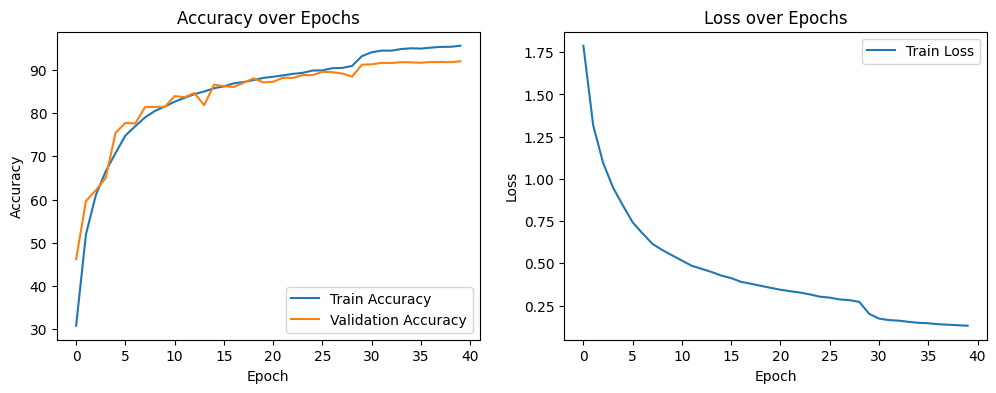

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(valid_acc_list, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Test Dataset (No Labels - submission.csv)

In [ ]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

In [ ]:
def load_submission_data():
    submission_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')
    submission_images = submission_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return submission_images

submission_images = load_submission_data()

In [ ]:
class CIFAR10SubmissionDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        images: NumPy array of images
        transform: A function/transform that takes in an image and returns a transformed version
        """
        self.images = images.transpose((0, 3, 1, 2))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        
        # Transform the image if a transform is provided
        if self.transform:
            image = torch.tensor(image, dtype=torch.float).div(255)
            image = transforms.functional.to_pil_image(image)
            image = self.transform(image)
        
        return image

# Now using the custom dataset class for submission images
# submission_images_tensor = torch.tensor(submission_images.transpose((0, 3, 1, 2))).float()
submission_dataset = CIFAR10SubmissionDataset(submission_images, transform=transform_test)
submission_loader = DataLoader(submission_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def create_submission(model, device, submission_loader, output_file='submission.csv'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in submission_loader:
            images = batch.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().tolist())

    submission_df = pd.DataFrame({
        'ID': range(len(predictions)),
        'Label': predictions
    })
    
    submission_df.to_csv(output_file, index=False)
    print(f'Submission file created: {output_file}')

In [ ]:
create_submission(model, device, submission_loader)